In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
2018-05-11 15:59:17,843 : INFO : 'pattern' package not found; tag filters are not available for English


In [2]:
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [4]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_batch = train_data[0:10000]
test_batch = test_data[0:5000]

In [5]:
def build_sentences_vector(sentence):
    words = sentence.split()
    result = np.zeros(100)
    size = 0
    for word in words:
        if word in embeding_model.wv.vocab:
            result+=embeding_model.wv[word]
            size+=1
    if size == 0:
        size = 1
    result /= size
    return result

In [6]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy                     %s' % accuracy_score(target, predictions))
    print('explained_variance_score     %s' % explained_variance_score(target, predictions))
    print('mean_absolute_error          %s' % mean_absolute_error(target, predictions))
    print('mean_squared_error           %s' % mean_squared_error(target, predictions))
    print('mean_squared_log_error       %s' % mean_squared_log_error(target, predictions))
    print('r2_score                     %s' % r2_score(target, predictions))
    print()
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
def plot_confusion_matrix(cm, title='Матрица ошибок', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = pd.unique(train_batch.stars)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('Исходные метки')
    plt.xlabel('Полученные метки')
    
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data.text)
    predictions = classifier.predict(data_features)
    target = data.stars
    evaluate_prediction(predictions, target)

In [7]:
embeding_model = Word2Vec.load('Yelp_embedings')
len(embeding_model.wv.vocab)

2018-05-11 15:59:35,978 : INFO : loading Word2Vec object from Yelp_embedings
2018-05-11 15:59:36,917 : INFO : loading wv recursively from Yelp_embedings.wv.* with mmap=None
2018-05-11 15:59:36,917 : INFO : setting ignored attribute vectors_norm to None
2018-05-11 15:59:36,919 : INFO : loading vocabulary recursively from Yelp_embedings.vocabulary.* with mmap=None
2018-05-11 15:59:36,919 : INFO : loading trainables recursively from Yelp_embedings.trainables.* with mmap=None
2018-05-11 15:59:36,921 : INFO : setting ignored attribute cum_table to None
2018-05-11 15:59:36,922 : INFO : loaded Yelp_embedings


101865

In [8]:
%%time
train_data_features = []
for sentense in train_batch.text:
    train_data_features.append(build_sentences_vector(sentense))
test_data_transform = []
for sentense in test_batch.text:
    test_data_transform.append(build_sentences_vector(sentense))

CPU times: user 7.54 s, sys: 37.6 ms, total: 7.58 s
Wall time: 7.54 s


In [11]:
features = range(0,100)
train_data_features = pd.DataFrame(train_data_features)
test_data_transform = pd.DataFrame(test_data_transform)

In [10]:
train_data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.657843,0.609632,0.525296,-0.276667,-1.599431,-0.746425,0.839047,-0.322020,-0.517576,0.034713,...,-0.550146,-0.719748,0.886963,0.559455,0.003304,-0.608013,1.656025,0.682780,-0.974621,0.092623
1,0.281443,0.327913,0.893144,-0.039593,-1.238828,-0.261439,0.226959,-0.302283,0.160297,0.748506,...,-0.099988,-1.136188,-0.067048,0.715835,0.564235,-0.053976,0.947576,-0.083399,-0.260778,1.018786
2,0.191129,0.250390,0.658530,-0.499258,-0.960555,-0.021281,-0.009629,-0.275409,-0.278017,0.424062,...,0.331823,-0.721983,-0.036767,1.221909,-0.014596,-0.161579,1.295473,-0.291968,-0.712597,0.343633
3,0.301239,0.069457,-0.562303,0.188611,-0.524861,-0.375607,0.690599,-0.122376,-0.060635,-0.128954,...,-0.233309,-0.686237,-0.459270,1.421436,0.658864,-0.730709,0.830375,-0.221889,-0.845500,0.968803
4,0.305067,1.077894,0.092685,-0.735038,-1.235901,-0.136614,-0.087349,-0.297884,-0.537728,-0.035349,...,-0.290039,-0.505505,0.562565,1.016297,0.043433,-0.299355,1.834400,0.132143,-0.594214,0.016543


In [12]:
big_X = train_data_features.append(test_data_transform)

In [13]:
%%time
scaler = MinMaxScaler()
scaler.fit(big_X)
train_data_features = scaler.transform(train_data_features)
test_data_transform = scaler.transform(test_data_transform)

CPU times: user 23.2 ms, sys: 7.98 ms, total: 31.2 ms
Wall time: 35.2 ms


In [18]:
tr_f = pd.DataFrame(train_data_features)
ts_f = pd.DataFrame(test_data_transform)
tr_f.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.577887,0.482078,0.742385,0.423349,0.310027,0.334578,0.600973,0.309871,0.397005,0.591023,...,0.391325,0.520636,0.718016,0.403269,0.559817,0.347468,0.727061,0.696300,0.363347,0.373897
1,0.493144,0.420949,0.819480,0.483888,0.392376,0.444563,0.457454,0.313837,0.571269,0.754721,...,0.522882,0.424707,0.486791,0.434370,0.712794,0.423916,0.534317,0.509378,0.520950,0.596806
2,0.472811,0.404128,0.770308,0.366507,0.455924,0.499027,0.401981,0.319237,0.458590,0.680314,...,0.649077,0.520121,0.494131,0.535019,0.554936,0.409069,0.628968,0.458494,0.421197,0.434310
3,0.497601,0.364868,0.514438,0.542163,0.555422,0.418672,0.566166,0.349987,0.514473,0.553488,...,0.483919,0.528355,0.391728,0.574701,0.738601,0.330538,0.502431,0.475591,0.391855,0.584776
4,0.498463,0.583684,0.651715,0.306298,0.393045,0.472871,0.383757,0.314721,0.391824,0.574955,...,0.467340,0.569987,0.639391,0.494126,0.570762,0.390058,0.775590,0.561963,0.447334,0.355586


In [19]:
tr_f.shape[0]
big_X = train_data_features.append(test_data_transform)
len(big_X)

15000

In [20]:
train_X = big_X[0:tr_f.shape[0]].as_matrix()
test_X = big_X[tr_f.shape[0]::].as_matrix()

In [21]:
%%time
# gbm = xgb.XGBClassifier(max_depth=48, n_estimators=345, learning_rate=0.05, booster='gbtree')
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=50, learning_rate=0.05, booster='gbtree')

CPU times: user 48 µs, sys: 2 µs, total: 50 µs
Wall time: 162 µs


In [22]:
%%time
gbm.fit(train_X, train_batch.stars, verbose=True)

CPU times: user 53.9 s, sys: 15.1 ms, total: 53.9 s
Wall time: 54 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
%%time
predictions = gbm.predict(test_X)

CPU times: user 218 ms, sys: 18 µs, total: 218 ms
Wall time: 230 ms


/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy                     0.5754
explained_variance_score     0.38034245485787543
mean_absolute_error          0.647
mean_squared_error           1.3186
mean_squared_log_error       0.09256217397620849
r2_score                     0.3564177711395433

confusion matrix
 [[ 450   70   38   46   90]
 [ 109   66   57  105   67]
 [  63   53  109  287  113]
 [  42   36   45  471  546]
 [  43   13   22  278 1781]]
(row=expected, col=predicted)


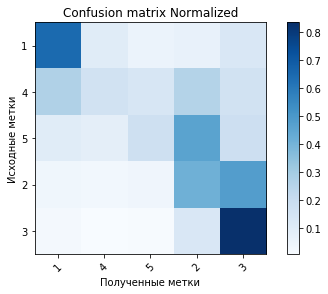

In [24]:
evaluate_prediction(predictions, test_batch.stars)